# IMAGE PREPROSSING AND U-NET TRAINING NOTEBOOK

### Import Packages

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from patchify import patchify, unpatchify

import tensorflow as tf

import cv2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


### Set Parameters

In [3]:
# Set some parameters
# IMG_WIDTH = 1536
# IMG_HEIGHT = 1536
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

train = "E:/Han Project/TrainingDataset/Images/"

#TRAIN_IMG_PATH = 'TrainingDataset/Images/'
TRAIN_IMG_PATH = 'D:/Han Project/TrainingDataset/ImagesJPG/'
#TRAIN_IMG_PATH = 'D:/Leaves_dataset/dataset/images/field/acer_ginnala/' # test library of leaves to check outputs
TRAIN_IMG_PATH = 'D:/Han Project/TrainingDataset/TrainSubset/Images/'

#TRAIN_LABEL_PATH = 'TrainingDataset/Labels/'
#TRAIN_LABEL_PATH = 'D:/Han Project/TrainingDataset/LabelsJPG/'
TRAIN_LABEL_PATH = 'D:/Han Project/TrainingDataset/TrainSubset/Labels/'

TEST_PATH = "E:/Han Project/TrainingDataset/test/Images/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Make empty numpy arrays with the size of the images in the folder

In [10]:
# Get train and test IDs
train_img_ids = next(os.walk(TRAIN_IMG_PATH))[2]
#print(train_img_ids)
print(len(train_img_ids))
#print("train img ids:", train_img_ids)
train_label_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]
#final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

X_train = np.zeros((len(train_img_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_label_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

#dataset = tf.data.Dataset.zip((dataset1, dataset2))
#dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

StopIteration: 

In [11]:
test_ids = next(os.walk(TEST_PATH))[2]

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


### Download patched images

In [9]:
from patchify import patchify, unpatchify

sys.stdout.flush()
n = 0
resizing_errors = 0
appending_img_to_array_error = 0
input_size = 512
print("Looping through:", TRAIN_IMG_PATH)
for path in os.listdir(TRAIN_IMG_PATH):
    if not os.path.isfile(TRAIN_IMG_PATH + path):
        print("folder not a file")
        continue
    img = cv2.imread(TRAIN_IMG_PATH + path)
    
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        #print("error resizing")
        resizing_errors += 1
        continue
    patches = patchify(img, (input_size,input_size), step=input_size) # split image into 2*3 small 2*2 patches.
    for x in range(0,patches.shape[0]):
        for y in range(0, patches.shape[1]):
            cv2.imwrite("C:/Users/chris/Downloads/TrainingDataset/TrainSubset/image_blocks512JPG/" + str(x) + str(y) + path, patches[x,y])
            n += 1
    
print("resizing errors:", resizing_errors)
print("Appending errors:", appending_img_to_array_error)
print("Total Images:", n)

#plt.imshow(X_train[0])
#plt.show()

Looping through: D:/Han Project/TrainingDataset/TrainSubset/Images/
resizing errors: 0
Appending errors: 0
Total Images: 41


In [8]:
sys.stdout.flush()
n = 0
resizing_errors = 0
appending_img_to_array_error = 0
print("Looping through:", TRAIN_LABEL_PATH)
for path in os.listdir(TRAIN_LABEL_PATH):
    if not os.path.isfile(TRAIN_LABEL_PATH + path):
        print("folder not a file")
        continue
    img = cv2.imread(TRAIN_LABEL_PATH + path)
    
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        #print("error resizing")
        resizing_errors += 1
        continue
    patches = patchify(img, (input_size,input_size), step=input_size) # split image into 2*3 small 2*2 patches.
    for x in range(0,patches.shape[0]):
        for y in range(0, patches.shape[1]):
            cv2.imwrite("C:/Users/chris/TrainingDataset/TrainSubset/label_blocks512JPG/" + str(x) + str(y) + path, patches[x,y])
            n += 1

print("resizing errors:", resizing_errors)
print("Appending errors:", appending_img_to_array_error)
print("Total Images:", n)

#plt.imshow(X_train[0])
#plt.show()

Looping through: D:/Han Project/TrainingDataset/LabelsJPG/
resizing errors: 0
Appending errors: 0
Total Images: 163709


## Create dataset

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Han Project/TrainingDataset/training_patches/',
    labels="inferred",
    label_mode="int",
    class_names=['image_blocks128JPG', 'label_blocks128JPG'],
    color_mode="grayscale",
    batch_size=4,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
print(dataset)

Found 323038 files belonging to 2 classes.
Using 290735 files for training.
<BatchDataset shapes: ((None, 128, 128, 1), (None,)), types: (tf.float32, tf.int32)>


## BatchLoader

In [156]:
class BatchLoad(keras.utils.Sequence):
    def __init__(self,
                 paths,
                 batch_size = 1,
                 dim = (512, 512, 1),
                 num_classes = 1):
        self.paths = paths
        self.batch_size = batch_size
        self.dim = dim
        self.num_classes = num_classes
        
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __data_generation(self, batch_paths):

        # Initialization
        images = np.empty((self.batch_size, *self.dim))  # define the numpy array for the batch
        masks = np.empty((self.batch_size, self.dim[0], self.dim[1], self.num_classes), dtype=bool)
        i = 0
        for path in batch_paths:
            img = cv2.imread("D:/Han Project/TrainingDataset/" + "Images/" + path)
            lab = cv2.imread("D:/Han Project/TrainingDataset/" + "Labels/" + path)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            lab = cv2.cvtColor(lab, cv2.COLOR_BGR2GRAY)
            
            print("shape:", img.shape)
            
            input_size = 512
            image_patches = patchify(img, (input_size,input_size), step=input_size)
            label_patches = patchify(lab, (input_size,input_size), step=input_size)
            num_patch = len(image_patches) - 1
            rand_patch = random.randint(0, num_patch) 
            print("image shape:", image_patches[rand_patch].shape)
            print("reshape:", image_patches[rand_patch].reshape(512,512,-1).shape)
            images[i] = image_patches[rand_patch].reshape(512,512,-1)
            masks[i] = label_patches[rand_patch].reshape(512,512,-1)
            i += 1
        return images, masks
    
    def __getitem__(self, index):
       
        paths_temp = os.listdir("D:/Han Project/TrainingDataset/" + "Images/")[index * self.batch_size:(index + 1) * self.batch_size]
        
        # can augment here
        images, masks = self.__data_generation(paths_temp)
        
        return images, masks

In [138]:
class BatchLoad(keras.utils.Sequence):
    def __init__(self,
                 paths,
                 batch_size = 1,
                 dim = (512, 512, 1),
                 num_classes = 1):
        self.paths = paths
        self.batch_size = batch_size
        self.dim = dim
        self.num_classes = num_classes
        
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __data_generation(self, batch_paths):

        # Initialization
        images = np.empty((self.batch_size, *self.dim))  # define the numpy array for the batch
        masks = np.empty((self.batch_size, self.dim[0], self.dim[1], self.num_classes), dtype=bool)
        i = 0
        for path in batch_paths:
            img = cv2.imread(batch_paths + "Images/" + path)
            lab = cv2.imread(batch_paths + "Labels/" + path)
            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                lab = cv2.cvtColor(lab, cv2.COLOR_BGR2GRAY)
            except:
                continue
            
            input_size = 512
            image_patches = patchify(img, (input_size,input_size), step=input_size)
            label_patches = patchify(lab, (input_size,input_size), step=input_size)
            num_patch = len(image_patches) - 1
            rand_patch = random.randint(0, num_patch) 
            images[i] = image_patches[rand_patch].reshape(512,512,1)
            masks[i] = label_patches[rand_patch].reshape(512,512,1)
            i += 1
        return images, masks
    
    def __getitem__(self, index):
       
        paths_temp = os.listdir("D:/Han Project/TrainingDataset/TrainSubset/" + "Images/")[index * self.batch_size:(index + 1) * self.batch_size]
        
        # can augment here
        images, masks = self.__data_generation(paths_temp)
        
        return images, masks

In [44]:
for path in os.listdir(train + "Images/"):
    print(train + "Images/" + path)
    img = cv2.imread(train + "Images/" + path)
    lab = cv2.imread(train + "Labels/" + path)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lab = cv2.cvtColor(lab, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        #print("error resizing")
        resizing_errors += 1
        continue

D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-paxillin001.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-paxillin002.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-paxillin003.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-vinculin001.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-vinculin002.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/CHOK1-vinculin003.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax001.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax002.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax003.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax004.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax005.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax006.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax007.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax008.jpg
D:/Han Project/TrainingDataset/TrainSubset/Images/Pax009.jpg
D:/Han Project/Trai

## Load Training images

In [5]:
sys.stdout.flush()
n = 0
resizing_errors = 0
appending_img_to_array_error = 0
print("Looping through:", TRAIN_IMG_PATH)
#print("os.listdir:", os.listdir(TRAIN_IMG_PATH))
for path in os.listdir(TRAIN_IMG_PATH):
    #Read image files iteratively
    #print("path:", TRAIN_IMG_PATH + path)
    if not os.path.isfile(TRAIN_IMG_PATH + path):
        print("folder not a file")
        continue
    #img = imread(path, plugin='pil')[:,:,:IMG_CHANNELS]
    img = cv2.imread(TRAIN_IMG_PATH + path)
    
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
    except Exception as e:
        #print("error resizing")
        resizing_errors += 1
        continue
        
    img = np.expand_dims(img, axis=-1)
    
    #img = tf.image.adjust_brightness(img, delta = .5)
    #tf.image.adjust_contrast(img, 5)
    #tf.image.adjust_saturation(img, 0.5)
    
    #Append image to numpy array for train dataset
    #img = (img/256).astype('uint8')
    #print(img.shape)
    try:
        X_train[n] = img
    except Exception as e:
        print("error: continuing though")
        print(e)
        print(path)
        print(img.shape)
        appending_img_to_array_error += 1
        pass
    n += 1
    #print(path)
print("resizing errors:", resizing_errors);
print("Appending errors:", appending_img_to_array_error)
print("Total Images:", n)

#plt.imshow(X_train[0])
#plt.show()

Looping through: D:/Han Project/TrainingDataset/TrainSubset/Images/
resizing errors: 0
Appending errors: 0
Total Images: 41


(41, 512, 512, 1)


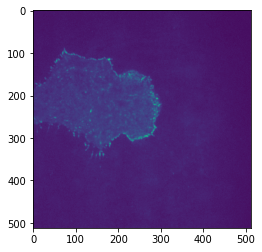

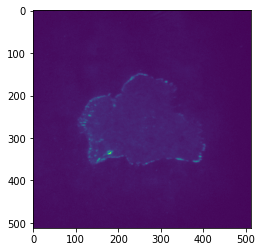

In [15]:
print(X_train.shape)
plt.imshow(X_train[20])
plt.show()
plt.imshow(X_train[10])
plt.show()

In [7]:
training_patches = tf.image.extract_patches(images=X_train,
                           sizes=[1, 128, 128, 1],
                           strides=[1, 64, 64, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [10]:
train_patch = np.zeros((len(train_img_ids*4), 128, 128, 1), dtype=np.uint8)
for imgs in training_patches:
    print("imgs:", imgs)
    count = 0
    for r in range(2):
        for c in range(2):
            train_patch[count] = tf.reshape(imgs[r,c],shape=(128,128,1)).numpy().astype("uint8")
            count += 1
    break
    
train_patch.shape

imgs: tf.Tensor(
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], shape=(7, 7, 16384), dtype=uint8)


(5124, 128, 128, 1)

## Visualization of patches

(1281, 7, 7, 16384)
imgs: tf.Tensor(
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], shape=(7, 7, 16384), dtype=uint8)


InvalidArgumentError: Input to reshape is a tensor with 16384 values, but the requested shape has 49152 [Op:Reshape]

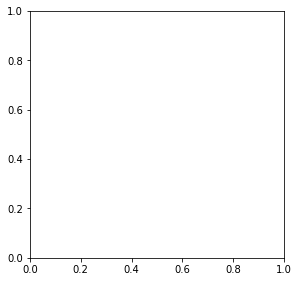

In [11]:
print(training_patches.shape)
plt.figure(figsize=(10, 10))
for imgs in training_patches:
    print("imgs:", imgs)
    count = 0
    for r in range(2):
        for c in range(2):
            ax = plt.subplot(2, 2, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,3)).numpy().astype("uint8"))
            plt.imsave(str(count) + ".jpg", tf.reshape(imgs[r,c],shape=(128,128,3)).numpy().astype("uint8"))
            count += 1
    plt.show()
    break

### Testing Automatic Brightness and Constrast

In [ ]:
#import cv2
#import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=25):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    print(maximum_gray)
    print(len(accumulator))
    print(accumulator[maximum_gray])
    print("max - clip:", maximum - clip_hist_percent)
    try:
        while (accumulator[maximum_gray] >= (maximum - clip_hist_percent)):
            maximum_gray -= 1
            #print(accumulator[maximum_gray])
    except:
        print("max - clip:", maximum - clip_hist_percent)
        pass
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


In [ ]:
image = cv2.imread('3T3_FlpIN_GFP_RIAM_mRb2_PAXILLIN_6_w1MCherry_s1_t1.TIF')
auto_result, alpha, beta = automatic_brightness_and_contrast(image)
print('alpha', alpha)
print('beta', beta)
plt.imshow(auto_result)
plt.show()
#cv2.imshow('auto_result', auto_result)
cv2.imwrite('auto_result.png', auto_result)
#cv2.imshow('image', image)
#cv2.waitKey()

## Load Training Labels

resizing errors: 0
Appending errors: 0
rgb to grey errors: 0
Total Images: 41
(41, 512, 512, 1)


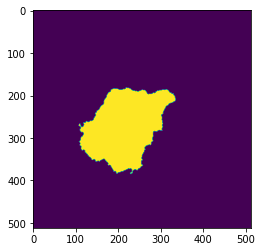

In [6]:
sys.stdout.flush()
n = 0
resizing_errors = 0
appending_img_to_array_error = 0
rgbtogrey_error = 0
for path in os.listdir(TRAIN_LABEL_PATH):
    #Read image files iteratively
    if not os.path.isfile(TRAIN_LABEL_PATH + path):
        continue
    #img = imread(path, plugin='pil')[:,:,:IMG_CHANNELS]
    #print("path:", TRAIN_LABEL_PATH + path)
    img = cv2.imread(TRAIN_LABEL_PATH + path)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        print(e)
        rgbtogrey_error += 1
        continue
   
    #(thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    #print(img.shape)
    try:
        img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
    except Exception as e:
        #print("error resizing")
        print(e)
        resizing_errors += 1
        continue
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
    img = np.expand_dims(img, axis=-1)
    
    #Append image to numpy array for train dataset
    
    try:
        Y_train[n] = img
    except Exception as e:
        print("error: continuing though")
        print(e)
        appending_img_to_array_error += 1
        pass
    n += 1
print("resizing errors:", resizing_errors);
print("Appending errors:", appending_img_to_array_error)
print("rgb to grey errors:", rgbtogrey_error)
print("Total Images:", n)


print(Y_train.shape)
plt.imshow(Y_train[0])
plt.show()


In [13]:
label_patches = tf.image.extract_patches(images=Y_train,
                           sizes=[1, 128, 128, 1],
                           strides=[1, 128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
print(label_patches.shape)
## TODO PICK UP HERE, trying to get (128,128,3) shape. Look at visiaulize function for way to do this. Probably need 2 more loops.
#for i in testing_patches:
#    tf.reshape(imgs[r,c],shape=(128,128,3)).numpy().astype("uint8")

(1281, 4, 4, 16384)


In [14]:
label_patch = np.zeros((len(train_label_ids*4), 128, 128, 1), dtype=np.uint8)
for imgs in label_patches:
    #print("imgs:", imgs)
    count = 0
    for r in range(2):
        for c in range(2):
            #ax = plt.subplot(2, 2, count+1)
            #print(imgs[r,c])
            label_patch[count] = tf.reshape(imgs[r,c],shape=(128,128,1)).numpy().astype("uint8")
            count += 1
    break
label_patch.shape

(5124, 128, 128, 1)

In [9]:
bool_y_train = testing_patches > 0
print(bool_y_train.dtype)
print(testing_patches.dtype)
print(bool_y_train.shape)

NameError: name 'testing_patches' is not defined

## Loading Test Images

4
E:/Han Project/TrainingDataset/test/Images/3T3_paxillin003.tif
(512, 512, 1)
(512, 512, 1)


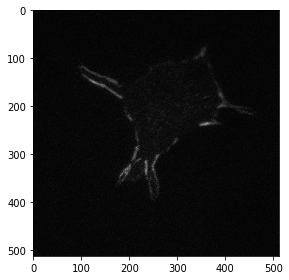

E:/Han Project/TrainingDataset/test/Images/3T3_vinculin002.tif
(512, 512, 1)
(512, 512, 1)


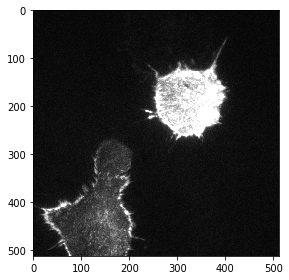

E:/Han Project/TrainingDataset/test/Images/CHOK1-vinculin001.jpg
(512, 512, 1)
(512, 512, 1)


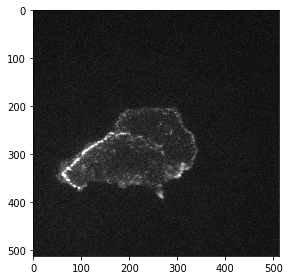

E:/Han Project/TrainingDataset/test/Images/VINC001.jpg
(512, 512, 1)
(512, 512, 1)


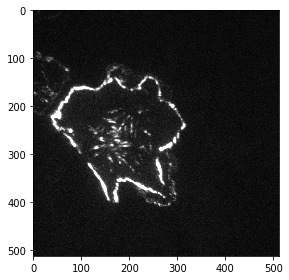

In [31]:
sys.stdout.flush()
n = 0
sizes_test = []
input_size = 512
print(len(os.listdir(TEST_PATH)))
for path in os.listdir(TEST_PATH):
    print(TEST_PATH + path)
    #Read image files iteratively
    if not os.path.isfile(TEST_PATH + path):
        print("not an image")
        continue
    #img = imread(path, plugin='pil')[:,:,:IMG_CHANNELS]
    img = cv2.imread(TEST_PATH + path, 0)
    
    #Get test size
    #sizes_test.append([img.shape[0], img.shape[1]])
    #print(img.shape)
    
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    try:
        img = cv2.resize(img, (512,512))
        img = np.expand_dims(img, axis=-1)

        print(img.shape)


        #Append image to numpy array for train dataset
        X_test[n] = img
        n += 1
        
        
    except:
        print("error")
    print(img.shape)
    imshow(img)
    plt.show()


In [108]:
test_patches = tf.image.extract_patches(images=X_test,
                           sizes=[1, input_size, input_size, 1],
                           strides=[1, input_size, input_size, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

32
4


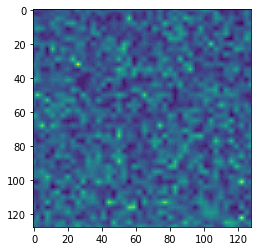

In [28]:
test_patch = np.zeros((len(test_ids*4), input_size, input_size, 1), dtype=np.uint8)
print(len(test_ids*4))
#print(test_patches[1,1])

for imgs in test_patches:
    #print("imgs:", imgs)
    count = 0
    for r in range(2):
        for c in range(2):
            #ax = plt.subplot(2, 2, count+1)
            #print(imgs.shape)
            #print(r,c)
            #print(imgs[r,c])
            plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,1)).numpy().astype("uint8"))
            test_patch[count] = tf.reshape(imgs[r,c],shape=(input_size,input_size,1)).numpy().astype("uint8")
            

            count += 1
            
print(count)

### Look at some sample images from each image set

In [11]:
#ix = random.randint(0, len(train_img_ids)-1)
#imshow(X_train[ix])
#plt.show()
#imshow(np.squeeze(Y_train[ix]))
#plt.show()
print(X_test.shape)
print(X_test[0].shape)
for i in range(0,5):
    print(i)
    imshow(X_test[i])
    plt.show()

NameError: name 'X_test' is not defined

## Scoring Functions

In [7]:
def dice_plus_bce_loss(targets, inputs, smooth=1e-6):
    # flatten label and prediction tensors
    inputs_dice = K.flatten(tf.cast(inputs, tf.float32))
    inputs_bce = K.flatten(tf.cast(inputs, tf.float32))
    targets = K.flatten(tf.cast(targets, tf.float32))

    intersection = K.sum(targets * inputs_dice)

    dice = (2 * intersection) / (K.sum(targets) + K.sum(inputs_dice) + smooth)

    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    bce = bce(targets, inputs_bce)

    return -K.log(dice + smooth)

def dice_scoring(targets, inputs, smooth=1e-6):
    # flatten label and prediction tensors
    inputs = K.flatten(tf.cast(inputs, tf.float32))
    targets = K.flatten(tf.cast(targets, tf.float32))

    intersection = K.sum(targets * inputs)
    dice = (2 * intersection) / (K.sum(targets) + K.sum(inputs) + smooth)
    return dice


## Build U-Net model

In [6]:
# Build U-Net model
inputs = Input((input_size, input_size, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, 1, activation='sigmoid', name='output') (c9)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_plus_bce_loss, metrics=['dice_scoring'])
# model.summary()

NameError: name 'dice_plus_bce_loss' is not defined

In [8]:
class UNetPlusPlus(object):

    def __init__(self, n_filter=16, input_dim=(512, 512, 1), learning_rate=3e-5, num_classes=1):
        self.n_filter = n_filter
        self.input = Input(input_dim)
        self.lr = learning_rate
        self.num_classes = num_classes

    def create_model(self):
        # ######### Frame 1 ######### #

        # X00 (Top layer, no up-sample)
        conv_x00 = convolution_relu_test(self.n_filter, 3)(self.input)
        skip_x00 = convolution_relu_test(self.n_filter, 3)(conv_x00)
        down_x00 = MaxPooling2D(pool_size=(2, 2))(skip_x00)

        # X10
        conv_x10 = convolution_relu_test(self.n_filter * 2, 3)(down_x00)
        skip_x10 = convolution_relu_test(self.n_filter * 2, 3)(conv_x10)
        up_x10 = convolution_relu_test(self.n_filter, 3)(UpSampling2D(size=(2, 2))(skip_x10))
        down_x10 = MaxPooling2D(pool_size=(2, 2))(skip_x10)

        # X20
        conv_x20 = convolution_relu_test(self.n_filter * 4, 3)(down_x10)
        skip_x20 = convolution_relu_test(self.n_filter * 4, 3)(conv_x20)
        up_x20 = convolution_relu_test(self.n_filter * 2, 3)(UpSampling2D(size=(2, 2))(skip_x20))
        down_x20 = MaxPooling2D(pool_size=(2, 2))(skip_x20)

        # X30
        conv_x30 = convolution_relu_test(self.n_filter * 8, 3)(down_x20)
        skip_x30 = convolution_relu_test(self.n_filter * 8, 3)(conv_x30)
        up_x30 = convolution_relu_test(self.n_filter * 4, 3)(UpSampling2D(size=(2, 2))(skip_x30))
        down_x30 = MaxPooling2D(pool_size=(2, 2))(skip_x30)

        # X40 (Deepest point)
        conv_x40 = convolution_relu_test(self.n_filter * 16, 3)(down_x30)
        skip_x40 = convolution_relu_test(self.n_filter * 16, 3)(conv_x40)  # This skip connection will not be used later
        up_x40 = convolution_relu_test(self.n_filter * 8, 3)(UpSampling2D(size=(2, 2))(skip_x40))

        # ######### Frame 2 ######### #

        # X01
        merge_x01 = concatenate([skip_x00, up_x10], axis=3)
        conv_x01 = convolution_relu_test(self.n_filter, 3)(merge_x01)
        skip_x01 = convolution_relu_test(self.n_filter, 3)(conv_x01)

        # X11
        merge_x11 = concatenate([skip_x10, up_x20], axis=3)
        conv_x11 = convolution_relu_test(self.n_filter * 2, 3)(merge_x11)
        skip_x11 = convolution_relu_test(self.n_filter * 2, 3)(conv_x11)
        up_x11 = convolution_relu_test(self.n_filter, 3)(UpSampling2D(size=(2, 2))(skip_x11))

        # X21
        merge_x21 = concatenate([skip_x20, up_x30], axis=3)
        conv_x21 = convolution_relu_test(self.n_filter * 4, 3)(merge_x21)
        skip_x21 = convolution_relu_test(self.n_filter * 4, 3)(conv_x21)
        up_x21 = convolution_relu_test(self.n_filter * 2, 3)(UpSampling2D(size=(2, 2))(skip_x21))

        # X31
        merge_x31 = concatenate([skip_x30, up_x40], axis=3)
        conv_x31 = convolution_relu_test(self.n_filter * 8, 3)(merge_x31)
        skip_x31 = convolution_relu_test(self.n_filter * 8, 3)(conv_x31)  # will not be used later
        up_x31 = convolution_relu_test(self.n_filter * 4, 3)(UpSampling2D(size=(2, 2))(skip_x31))

        # ######### Frame 3 ######### #

        # X02
        merge_x02 = concatenate([skip_x00, skip_x01, up_x11], axis=3)
        conv_x02 = convolution_relu_test(self.n_filter, 3)(merge_x02)
        skip_x02 = convolution_relu_test(self.n_filter, 3)(conv_x02)

        # X12
        merge_x12 = concatenate([skip_x10, skip_x11, up_x21], axis=3)
        conv_x12 = convolution_relu_test(self.n_filter * 2, 3)(merge_x12)
        skip_x12 = convolution_relu_test(self.n_filter * 2, 3)(conv_x12)
        up_x12 = convolution_relu_test(self.n_filter, 3)(UpSampling2D(size=(2, 2))(skip_x12))

        # X22
        merge_x22 = concatenate([skip_x20, skip_x21, up_x31], axis=3)
        conv_x22 = convolution_relu_test(self.n_filter * 4, 3)(merge_x22)
        skip_x22 = convolution_relu_test(self.n_filter * 4, 3)(conv_x22)  # will not be used later
        up_x22 = convolution_relu_test(self.n_filter * 2, 3)(UpSampling2D(size=(2, 2))(skip_x22))

        # ######### Frame 4 ######### #

        # X03
        merge_x03 = concatenate([skip_x00, skip_x01, skip_x02, up_x12], axis=3)
        conv_x03 = convolution_relu_test(self.n_filter, 3)(merge_x03)
        conv_x03 = BatchNormalization()(conv_x03)
        skip_x03 = convolution_relu_test(self.n_filter, 3)(conv_x03)

        # X13
        merge_x13 = concatenate([skip_x10, skip_x11, skip_x12, up_x22], axis=3)
        conv_x13 = convolution_relu_test(self.n_filter * 2, 3)(merge_x13)
        conv_x13 = BatchNormalization()(conv_x13)
        skip_x13 = convolution_relu_test(self.n_filter * 2, 3)(conv_x13)

        up_x13 = convolution_relu_test(self.n_filter, 3)(UpSampling2D(size=(2, 2))(skip_x13))

        # ######### Frame 5 ######### #

        # X04
        merge_x04 = concatenate([skip_x00, skip_x01, skip_x02, skip_x03, up_x13], axis=3)
        conv_x04 = convolution_relu_test(self.n_filter, 3, use_batchnorm=False, use_dropout=False)(merge_x04)
        out = convolution_relu_test(2, 3)(conv_x04)

        # ######### output ######### #
        output = Conv2D(self.num_classes, 1, activation='sigmoid')(out)

        model = Model(inputs=self.input, outputs=output)
        opt = Adam(lr=self.lr)
        opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)
        model.compile(optimizer=opt, loss=dice_plus_bce_loss, metrics=dice_scoring)
        # model.summary()
        return model

In [9]:
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.convolutional import UpSampling2D
from keras.layers.merge import concatenate
from keras.engine.input_layer import Input
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, Activation
from keras.engine.training import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

def convolution_relu_test(filters, kernel_size, use_batchnorm=True, use_dropout=True, drop_rate=0.05,
                          conv_name='conv', bn_name='bn', relu_name='selu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding='same', use_bias=not use_batchnorm)(x)
        if use_batchnorm:
            x = BatchNormalization()(x)
        if use_dropout:
            x = Dropout(drop_rate)(x)
        x = Activation(relu_name)(x)
        return x

    return layer
unet = UNetPlusPlus(n_filter=8,
                            input_dim=(512, 512, 1),
                            learning_rate=0.0001,
                            num_classes=1)
model = unet.create_model()
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 512, 512, 8)  72          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 8)  32         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                            

c:\users\chris\anaconda3\envs\tf-py3.8\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2d_48 (Conv2D)             (None, 128, 128, 32  27648       ['concatenate_10[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 512, 512, 8)  1152        ['concatenate_4[0][0]']          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 256, 256, 16  64         ['conv2d_35[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_39 (BatchN  (None, 256, 256, 16  64         ['conv2d_39[0][0]']              
 ormalization)                  )                                                                 
          

 ## Fit Model

In [9]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01)
#model.compile(loss = "categorical_crossentropy", optimizer = opt)
model.compile(loss = "categorical_crossentropy", optimizer = opt)

C:\Users\chris\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [157]:
# Fit model
from tqdm.keras import TqdmCallback
import glob
from pathlib import Path

tf.config.experimental_run_functions_eagerly(True)

earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('train_fullset512JPG25E.h5', verbose=0, save_best_only=False)

# image_names = []
# train_files_full_path = glob.glob(train_path)
# for path in train_files_full_path:
#     image_names.append(Path(path))

training_generator = BatchLoad(train, batch_size = 4)

results = model.fit(training_generator
                    , epochs=25,
                    callbacks=[earlystopper, checkpointer, TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape: (1536, 1536)
image shape: (3, 512, 512)
reshape: (512, 512, 3)


error: OpenCV(4.5.3) c:\users\runneradmin\appdata\local\temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x36d2c679::Set<1,-1,-1>,struct cv::impl::A0x36d2c679::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 512


In [11]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

In [5]:
from tensorflow import keras
from tqdm.keras import TqdmCallback
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    'D:/Han Project/TrainingDataset/TrainSubset/',
    labels="inferred",
    label_mode="int",
    class_names=['Images', 'Labels'],
    color_mode="grayscale",
    batch_size=4,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
# validation_ds = image_dataset_from_directory(
#     directory='validation_data/',
#     labels='inferred',
#     label_mode='categorical',
#     batch_size=32,
#     image_size=(256, 256))

# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     # Restrict TensorFlow to only use the first GPU
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [
#                     tf.config.experimental.VirtualDeviceConfiguration(
#                         memory_limit=6000  # set your limit
#                     )
#                 ],
#             )
#         tf.config.experimental.set_visible_devices(gpus[0], "GPU")
#         logical_gpus = tf.config.experimental.list_logical_devices("GPU")
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint512JPG10.h5', verbose=0, save_best_only=False)
model = keras.applications.MobileNetV2(weights=None, input_shape=(512, 512, 1), classes=1)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
model.fit(train_ds, epochs=2, callbacks=[earlystopper, checkpointer, TqdmCallback(verbose=1)])

Found 82 files belonging to 2 classes.
Using 74 files for training.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/2
19/19 [==============================] - 7s 150ms/step - loss: 0.5247


C:\Users\chris\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/2
19/19 [==============================] - 2s 129ms/step - loss: 0.3290


In [2]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
with cuda.gpus[0]:
    d_a = cuda.to_device(0)
    print(d_a)
    
print(cuda.list_devices())

<Managed Device 0>


In [ ]:
for i in os.listdir(train):
    print(i)
    try:
        img = cv2.imread(train + i)
        if img.shape == (512,512,3):
            print(i, "512 x 512")
    except:
        continue

In [21]:
train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
train.flow_from_directory(
    'D:/Han Project/TrainingDataset/training_patches/', target_size=(128, 128, 1), color_mode='grayscale', classes=['image_blocks128JPG', 'label_blocks128JPG'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='TIF',
    follow_links=False, subset=None, interpolation='nearest'
)


Found 323038 images belonging to 2 classes.


In [40]:
train.fit(X_test)

## Repatch Images

In [19]:
def extract_patches(x):
    return tf.image.extract_patches(
        x,
        (1, 128, 128, 1),
        (1, 128, 128, 1),
        (1, 1, 1, 1),
        padding="VALID"
    )

In [22]:
def extract_patches_inverse(x, y):
    tf.config.run_functions_eagerly(False)
    _x = tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return tf.gradients(_y, _x, grad_ys=y)[0] / grad

In [ ]:
images_reconstructed = extract_patches_inverse(X_train, training_patches) 
labels_reconstructed = extract_patches_inverse(Y_train, label_patches) 
tf.config.experimental_run_functions_eagerly(True)

## Run Predictions

In [32]:
# Predict on patches
model = load_model('h5_files/train_subset512JPG10E.h5',
                  custom_objects = { 'dice_plus_bce_loss': dice_plus_bce_loss,
                                    'dice_scoring': dice_scoring})
#preds_train = model.predict(train_patch[:int(train_patch.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(train_patch[int(train_patch.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 450ms/step


In [ ]:
# Predict on train, val and test
model = load_model('train_subset_UNet512TIF10E-20220405-23.44.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

In [33]:
# Threshold predictions
#preds_train_t = (preds_train > 0.2).astype(np.uint8)
#preds_val_t = (preds_val > 0.2).astype(np.uint8)
preds_test_t = (preds_test > 0.2).astype(np.uint8)

In [14]:
# Create list of upsampled test masks
preds_test_upsampled = []
print("sizes test:", sizes_test)
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

sizes test: []


IndexError: list index out of range

xtest: (512, 512, 1)
8
(8, 512, 512, 1)
training images not loaded...
preds: (8, 512, 512, 1)


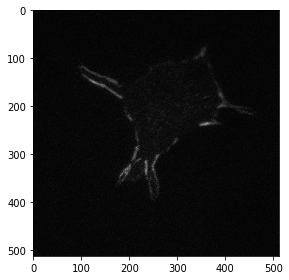

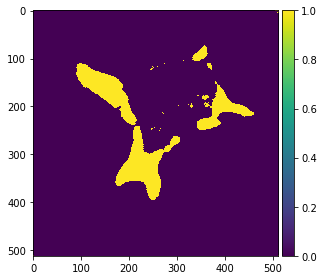

preds: (8, 512, 512, 1)


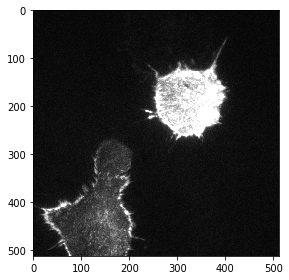

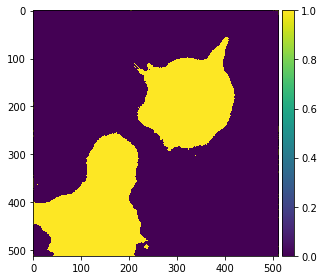

preds: (8, 512, 512, 1)


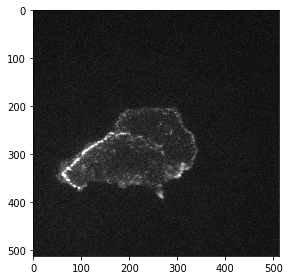

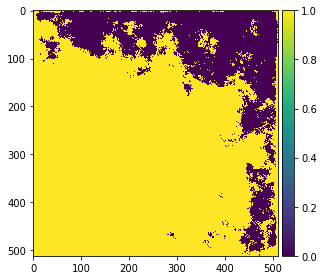

preds: (8, 512, 512, 1)


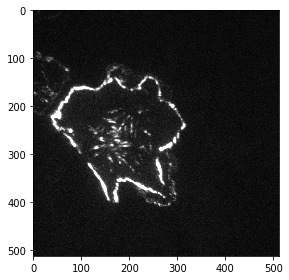

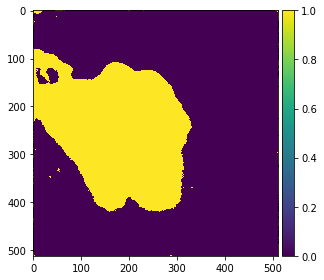

preds: (8, 512, 512, 1)


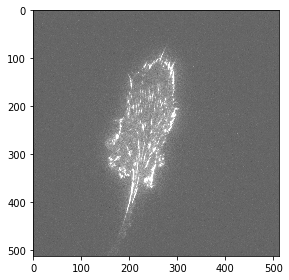

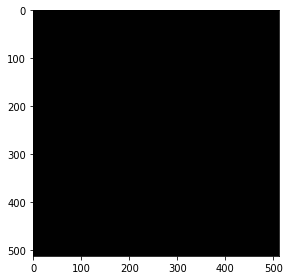

preds: (8, 512, 512, 1)


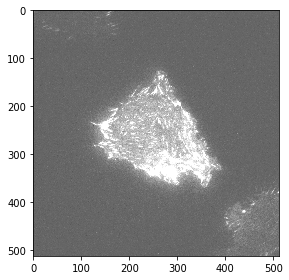

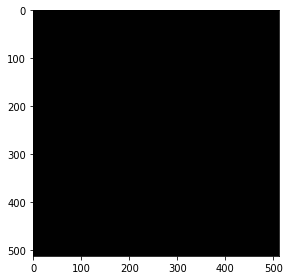

preds: (8, 512, 512, 1)


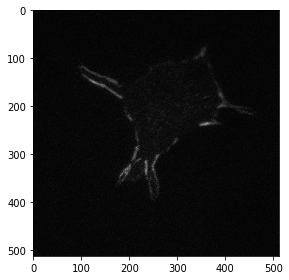

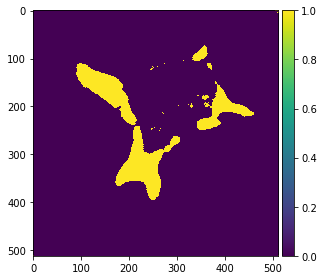

preds: (8, 512, 512, 1)


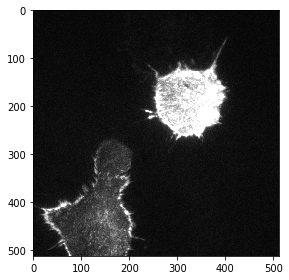

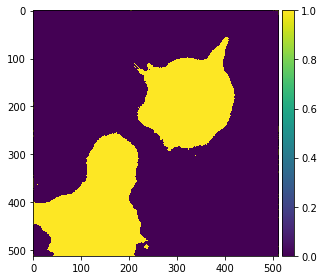

preds: (8, 512, 512, 1)


IndexError: index 8 is out of bounds for axis 0 with size 8

In [34]:
from skimage.filters import threshold_otsu
print("xtest:", X_test[0].shape)
print(len(preds_test_t))
print(preds_test_t.shape)
try:
    print(len(X_train))
    ix = random.randint(0, len(X_train))
    #imshow(X_train[0])
    #plt.show()
    #imshow(np.squeeze(Y_train[0]))
    #plt.show()
    #imshow(np.squeeze(preds_train_t[1]))
    #plt.show()
except:
    print("training images not loaded...")
for i in range(0,10):
    print("preds:",preds_test_t.shape)
    imshow(X_test[i])
    plt.show()

    imshow(preds_test_t[i])
    plt.show()

#preds_otsu_test = threshold_otsu(preds_test_t[12])
#imshow(preds_otsu_test)
#plt.show()